In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from  hmcSampler import HMCSampler

def U(q):
    return np.sum((y - model(q,x))**2,axis=1)/2.0

def dU(q):
    return np.sum((y - model(q,x))*(-1.0*dmodel(q,x)), axis=2)

def model(q,x):
    return np.polynomial.polynomial.polyval(x,q)
 
def dmodel(q,x):
    r = np.transpose(np.asarray([dx]*q.shape[1]),(1,0,2))
    return r


In [2]:
global y
global x
global dx

x = np.linspace(-2.0,2.0,100)
p = np.asarray([2.0,5.0,-1.0])
y = model(p,x) + np.random.randn(len(x))

indicies = np.arange(len(p))
xp = (x*np.ones((len(p),len(x)))).T
dx = np.power(xp,indicies).T

smp = HMCSampler()

smp.U = U
smp.dU = dU

smp.qi = np.asarray([1.5,4.0,0.0])

smp.n_samples = 1000
smp.n_burnin = 1000
smp.lf_length = 0.075

y0 = model(smp.qi,x)

smp.runHMC()

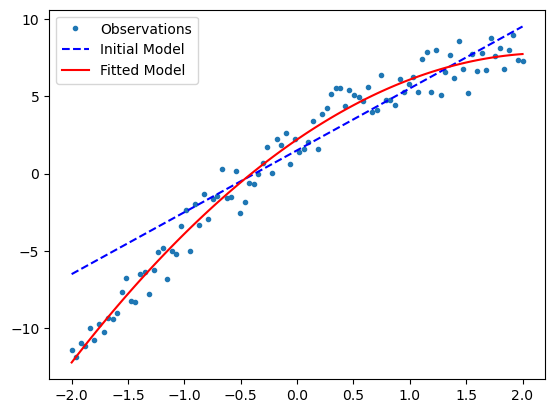

In [6]:
py = model((np.median(smp.samples,axis=0)),x)
plt.plot(x,y,'.')
plt.plot(x,y0,'b--')
plt.plot(x,py,'r-')
plt.legend(['Observations','Initial Model','Fitted Model'])
plt.show()


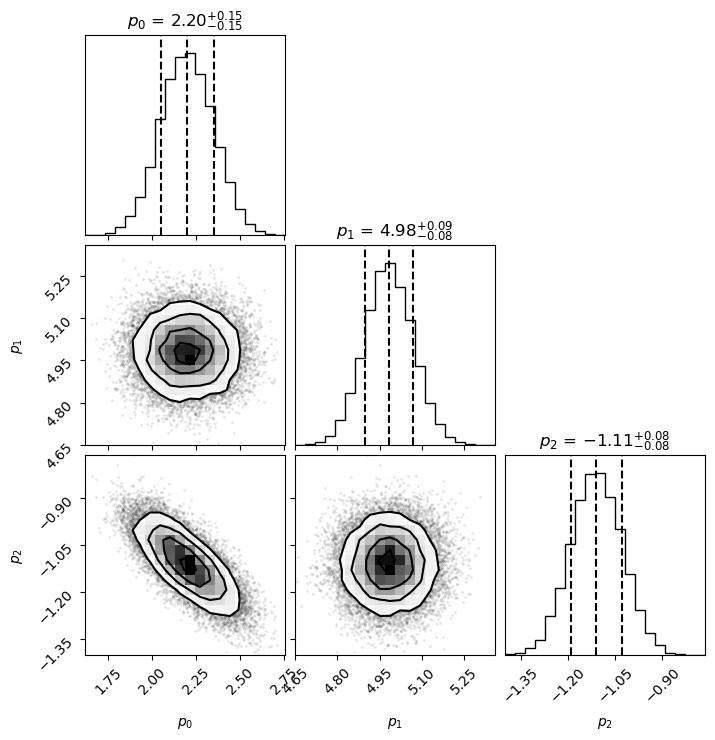

In [4]:
smp.plotSamples([r"$p_0$",r"$p_1$",r"$p_2$",r"$p_3$",r"$p_4$"])

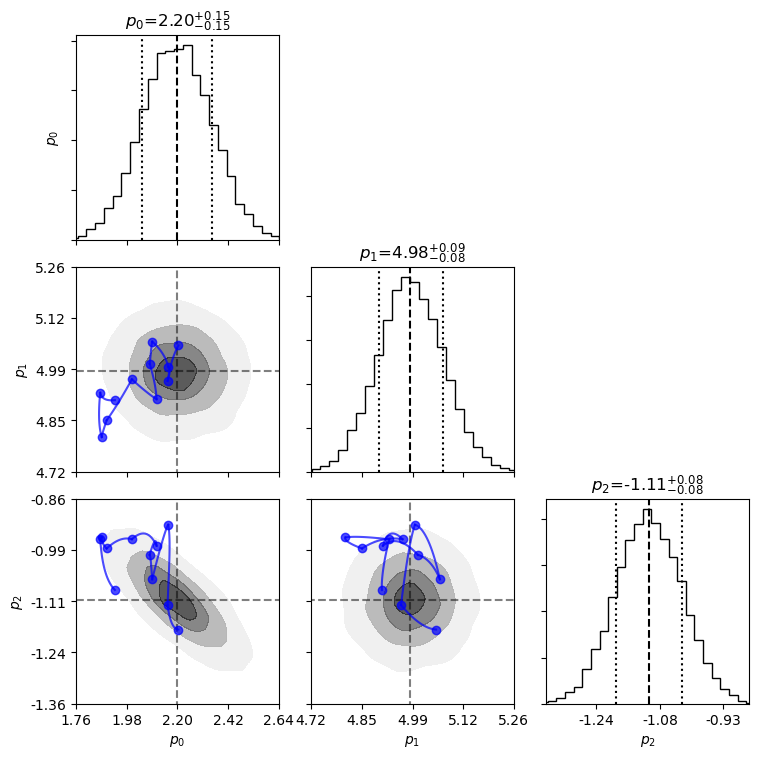

In [5]:
smp.plotOrbits(10,
               [r"$p_0$",r"$p_1$",r"$p_2$",r"$p_3$",r"$p_4$"])

